In [1]:
using Gen
using Plots
using DelimitedFiles

In [2]:
# helper function
function logmeanexp(scores)
    logsumexp(scores) - log(length(scores))
end;

# "Musical notes" example

We have 5 musical notes; a composition is defined by a set of stochastis transitions between notes. 

With probability 0.6 we stay on the current note; with probability 0.1, we transition to a new note.

Let's start with writing a generative model of such simple compositions. 

In [3]:
# helper functions to write the generative model
#

function transition_prob(a, b)
    a == b ? 0.6 : 0.1
end

# setup transition probabilities
function transition_prob_matrix()
    note_transitions = Array{Float64}(undef, 5, 5)
    for i=1:5
        [note_transitions[i, j] = transition_prob(i,j) for j=1:5]
    end
    return note_transitions
end

# make this variable global (makes some of the coding more straightforward)
global note_transitions = transition_prob_matrix()

5×5 Matrix{Float64}:
 0.6  0.1  0.1  0.1  0.1
 0.1  0.6  0.1  0.1  0.1
 0.1  0.1  0.6  0.1  0.1
 0.1  0.1  0.1  0.6  0.1
 0.1  0.1  0.1  0.1  0.6

Now, we can use this transition probabilities to actually define our generative model of compositions.

Notice that our observation space is a bit idiosyncratic. We assume that when a note is played, we observe a vector of a few real numbers, sampled from a Gaussian distribution. In a more realistic example, we would project each note to a [spectogram](https://musiclab.chromeexperiments.com/spectrogram/). 

In [4]:
@gen function musical_notes(K::Int)
    # sample an initial "note"
    current_note = {:notes => 1 => :θ} ~ uniform_discrete(1, 5)
    
    # "play" it: projecting it to "sensory features" of length 3
    note_play_length = 3
    mu = current_note * 0.1
    {:data => 1 => :y} ~ broadcasted_normal(repeat([mu], note_play_length), repeat([0.05], note_play_length))

    # keep going for K notes
    for k=1:K
        current_note = {:notes => k+1 => :θ} ~ categorical(note_transitions[current_note, :])
        mu = current_note * 0.1
        {:data => k+1 => :y} ~ broadcasted_normal(repeat([mu], note_play_length), repeat([0.05], note_play_length))
    end 
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Int64], false, Union{Nothing, Some{Any}}[nothing], var"##musical_notes#292", Bool[0], false)

In [5]:
trace = simulate(musical_notes, (10,))
get_choices(trace)

notes = Vector{Int}[]
features = Vector{Float64}[]
[push!(notes, [trace[:notes => k => :θ]]) for k=1:10]
[push!(features, trace[:data => k => :y]) for k=1:10]

10-element Vector{Vector{Vector{Float64}}}:
 [[0.44631213323017216, 0.4872637552033235, 0.5184067526073545], [0.44416934906174055, 0.3693154931019449, 0.4049118199840365], [0.3440859068143266, 0.3244018783590651, 0.35979628781467765], [0.4079331965395612, 0.4342928569319763, 0.3216346383575727], [0.353371608356647, 0.3920503919262861, 0.3838894934678421], [0.45588260631554495, 0.3560676893502729, 0.37447276630704357], [0.4068421783112881, 0.3971525447535644, 0.424493044830461], [0.41027561537888857, 0.37102352296461394, 0.41277049532696114], [0.11953483114352761, 0.10483989034557259, 0.16740747228947295], [0.13935571385873818, 0.0649189178201599, 0.06497484633071943]]
 [[0.44631213323017216, 0.4872637552033235, 0.5184067526073545], [0.44416934906174055, 0.3693154931019449, 0.4049118199840365], [0.3440859068143266, 0.3244018783590651, 0.35979628781467765], [0.4079331965395612, 0.4342928569319763, 0.3216346383575727], [0.353371608356647, 0.3920503919262861, 0.3838894934678421], [0.455882

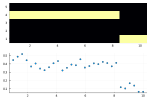

In [6]:
function visualize_notes(notes, features)
    K = length(notes)
    binary_notes = zeros(Int, 5, K)
    for k = 1:K
        binary_notes[notes[k][1], k] = 1
    end

    # plot the notes played
    p1 = plot(binary_notes, seriestype=:heatmap, legend=:none)

    # plot "audio"
    features = collect(Iterators.flatten(transpose(features)))
    p2 = plot(collect(range(1, K, length=length(features))), features, seriestype=:scatter)
    plot(p1, p2, layout=(2,1), legend=false)
end
visualize_notes(notes, features)

### code to save synthesized data -- 
# features_matrix = reduce(hcat, features)'
# writedlm("notes_observe_new.txt", features_matrix, ",")

In [7]:
function particle_filter(num_particles::Int, zs::Matrix{Float64}, num_samples::Int)

    #initital observation
    init_obs = Gen.choicemap((:data => 1 => :y, zs[1, :]))
    
    # initialize the particle filter (Step 0) -- 
    # sampling from the prior and weighting by the likelihood
    state = Gen.initialize_particle_filter(musical_notes, (0,), init_obs, num_particles)
    
    for k=1:size(zs)[1]-1
        # Evolve and resample (Step 1a, 1b)
        maybe_resample!(state, ess_threshold=num_particles/2)
        # load observations of this time step
        obs = Gen.choicemap((:data => k+1 => :y, zs[k+1,:]))
        # Re-weight by the likelihood (Step 2)
        Gen.particle_filter_step!(state, (k,), (UnknownChange(),), obs)
    end
    
    # return a sample of unweighted traces from the weighted collection
    return Gen.sample_unweighted_traces(state, num_samples)
end

particle_filter (generic function with 1 method)

In [8]:
# load observations (sensory features)
zs = readdlm("notes_observe.txt", ',')
# run particle filter with 1000 particles, 
# and return 100 unweighted posterior samples
pf_traces = particle_filter(1000, zs, 100);

In [9]:
# a polymorphic visualization function when the notes is a matrix already
function visualize_notes(notes::Matrix{Float64}, features)
    K = size(notes)[2]
    p1 = plot(notes, seriestype=:heatmap)
    features = collect(Iterators.flatten(transpose(features)))
    p2 = plot(collect(range(1, K, length=length(features))), features, seriestype=:scatter)
    plot(p1, p2, layout=(2,1), legend=false)
end

visualize_notes (generic function with 2 methods)

Log probability: 36.05829469440771


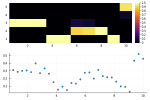

In [10]:
scores = Vector{Float64}(undef, 100)
inferred_notes = zeros(Int, 100, 10)
aggregate_notes_matrix = zeros(Float64, 5, 10)
for i=1:100
    tr = pf_traces[i]
    scores[i] = get_score(tr)
    for k = 1:size(zs)[1]
        inferred_notes[i, k] = tr[:notes => k => :θ]
        aggregate_notes_matrix[inferred_notes[i, k], k] += 1.0
    end
end

aggregate_notes_matrix = aggregate_notes_matrix ./ 100
println("Log probability: ", logmeanexp(scores))
visualize_notes(aggregate_notes_matrix, zs)

## Combinators: Map

Let's go back to our `unknown_urn` generative model for a moment.

In [11]:
@gen function unknown_urn()
    # p(θ) ̃Uniform(0,1)  [prior distribution]
    theta ~ uniform(0, 1)
    for i=1:100
        # p(y=1|θ) ~ Bernoulli(θ) [likelihood function]
        {:data => i => :y} ~ bernoulli(theta)
    end
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##unknown_urn#298", Bool[], false)

Let's start with writing the kernel for this loop

In [12]:
# kernel generative function G_k
@gen (static) function unknown_urn_flip_kernel(theta::Float64)
    # p(y|θ) ~ Bernoulli(θ) [likelihood function]
    y ~ bernoulli(theta)
    return y
end

var"##StaticGenFunction_unknown_urn_flip_kernel#307"(Dict{Symbol, Any}(), Dict{Symbol, Any}())

Now let's loop this within a static version of our unknown generative model

In [13]:
@gen (static) function unknown_urn_static(k::Int64)
    # prior over coin weight p(θ)
    theta ~ uniform(0,1)
    # called k times
    data ~ Gen.Map(unknown_urn_flip_kernel)(fill(theta, k))
end

var"##StaticGenFunction_unknown_urn_static#324"(Dict{Symbol, Any}(), Dict{Symbol, Any}())

In [14]:
# need this to load the static functions
@load_generated_functions

# get a draw and peek inside
(trace, _) = generate(unknown_urn_static, (3,))
get_choices(trace)

│
├── :theta : 0.5266814485773912
│
└── :data
    │
    ├── 1
    │   │
    │   └── :y : true
    │
    ├── 2
    │   │
    │   └── :y : true
    │
    └── 3
        │
        └── :y : true


### An additional `Map` example

In [15]:
# this is our kernel G_k
@gen function noisy_sum_kernel(x1::Float64, x2::Float64)
    # draw a normal based on the arguments 
    y = @trace(normal(x1 + x2, 1.0), :z)
    # and return it
    return y
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Float64, Float64], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##noisy_sum_kernel#336", Bool[0, 0], false)

In [16]:
# a new generative function using the Map combinator
noisy_sum = Map(noisy_sum_kernel)

Map{Any, Gen.DynamicDSLTrace}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Float64, Float64], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##noisy_sum_kernel#336", Bool[0, 0], false))

In [17]:
# need this to load the static functions
@load_generated_functions

(trace, _) = generate(noisy_sum, ([0.0, 0.5], [0.5, 1.0]))
get_choices(trace)

│
├── 1
│   │
│   └── :z : -1.5480032516599072
│
└── 2
    │
    └── :z : 1.0083627244370752


## The Unfold combinator for our musical note example

In [18]:
@gen function musical_notes_kernel(k::Int, prev_note)
    # draw the note
    current_note = {:θ} ~ categorical(note_transitions[prev_note, :])

    # how long it takes to play a note
    note_play_length = 3
    # draw the sensory features
    mu = current_note * 0.1
    {:y} ~ broadcasted_normal(repeat([mu], note_play_length), repeat([0.05], note_play_length))
    
    #return the current note for recursion
    return current_note
end

@gen function unfold_musical_notes(K::Int)    
    # sample an initial "note"
    init_note = uniform_discrete(1, 5)

    # call the temporal kernel and unfold it for K time steps
    music ~ Unfold(musical_notes_kernel)(K, init_note)

end


trace = simulate(unfold_musical_notes, (10,))
get_choices(trace)
notes = Vector{Int}[]
features = Vector{Float64}[]
[push!(notes, [trace[:music => k => :θ]]) for k=1:10]
[push!(features, trace[:music => k => :y]) for k=1:10]

10-element Vector{Vector{Vector{Float64}}}:
 [[0.08004584452918716, 0.06486887398829844, 0.11407959666190845], [0.07279295132197733, 0.1106532436576226, 0.01827479808851512], [0.134668749518362, 0.11225622468051735, 0.07049433832192291], [0.43081991815904885, 0.36070293225556926, 0.43380633079669756], [0.4510821820685395, 0.37815082970569425, 0.31989101925995855], [0.37616010684566137, 0.48003860807843496, 0.3276353901496343], [0.39638968379870254, 0.39603129487735655, 0.43753977854090814], [0.5081649361471433, 0.446995566569697, 0.6049704738065484], [0.553397381240155, 0.4772926993175851, 0.41516569787142704], [0.48568376135921, 0.5435987068259227, 0.5361622382048052]]
 [[0.08004584452918716, 0.06486887398829844, 0.11407959666190845], [0.07279295132197733, 0.1106532436576226, 0.01827479808851512], [0.134668749518362, 0.11225622468051735, 0.07049433832192291], [0.43081991815904885, 0.36070293225556926, 0.43380633079669756], [0.4510821820685395, 0.37815082970569425, 0.31989101925995855]

### With the (static) annotation

In [19]:
@gen (static) function musical_notes_kernel(k::Int, prev_note)
    # draw the note
    current_note = {:θ} ~ categorical(note_transitions[prev_note, :])

    # how long it takes to play a note
    note_play_length = 3
    # draw the sensory features
    mu = current_note * 0.1
    {:y} ~ broadcasted_normal(repeat([mu], note_play_length), repeat([0.05], note_play_length))
    
    #return the current note for recursion
    return current_note
end

@gen (static) function unfold_musical_notes(K::Int)    
    # sample an initial "note"
    init_note = uniform_discrete(1, 5)

    # call the temporal kernel and unfold it for K time steps
    music ~ Unfold(musical_notes_kernel)(K, init_note)

end

@load_generated_functions()
trace = simulate(unfold_musical_notes, (10,))
get_choices(trace)
notes = Vector{Int}[]
features = Vector{Float64}[]
[push!(notes, [trace[:music => k => :θ]]) for k=1:10]
[push!(features, trace[:music => k => :y]) for k=1:10]

10-element Vector{Vector{Vector{Float64}}}:
 [[0.07197471287138603, 0.1346952654733185, 0.04377375510228007], [0.0751392995658899, -0.002056514423530942, 0.048107169292554146], [0.44912182376451065, 0.34478220844636126, 0.4612266355881145], [0.402939305103505, 0.46241103846388615, 0.42384048428324805], [0.5873748141866986, 0.4809064176068911, 0.6121736103398835], [0.32514143654407796, 0.17427255795174826, 0.31580592668606483], [0.2631523730977515, 0.22278263756271857, 0.3421281180133454], [0.41038426369119796, 0.42920799411306737, 0.419079915941309], [0.3823345097727639, 0.45042888144792265, 0.36198479714362286], [0.43532620408409445, 0.4889049190242577, 0.4034132137267507]]
 [[0.07197471287138603, 0.1346952654733185, 0.04377375510228007], [0.0751392995658899, -0.002056514423530942, 0.048107169292554146], [0.44912182376451065, 0.34478220844636126, 0.4612266355881145], [0.402939305103505, 0.46241103846388615, 0.42384048428324805], [0.5873748141866986, 0.4809064176068911, 0.6121736103398

In [20]:
function particle_filter_with_unfold(num_particles::Int, zs::Matrix{Float64}, num_samples::Int)

    #initital observation
    init_obs = Gen.choicemap((:music => 0 => :y, zs[1, :]))
    
    # initialize the particle filter (Step 0) -- 
    # sampling from the prior and weighting by the likelihood
    state = Gen.initialize_particle_filter(unfold_musical_notes, (0,), init_obs, num_particles)
    
    for k=1:size(zs)[1]
        # Evolve and resample (Step 1a, 1b)
        maybe_resample!(state, ess_threshold=num_particles/2)
        # load observations of this time step
        obs = Gen.choicemap((:music => k => :y, zs[k,:]))
        # Re-weight by the likelihood (Step 2)
        Gen.particle_filter_step!(state, (k,), (UnknownChange(),), obs)
    end
    
    # return a sample of unweighted traces from the weighted collection
    return Gen.sample_unweighted_traces(state, num_samples)
end

particle_filter_with_unfold (generic function with 1 method)

Log probability: 36.70518632618499


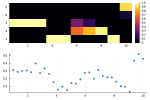

In [21]:
# load observations (sensory features)
zs = readdlm("notes_observe.txt", ',')
# run particle filter with 1000 particles, 
# and return 100 unweighted posterior samples
pf_traces = particle_filter_with_unfold(1000, zs, 100);

scores = Vector{Float64}(undef, 100)
inferred_notes = zeros(Int, 100, 10)
aggregate_notes_matrix = zeros(Float64, 5, 10)
for i=1:100
    tr = pf_traces[i]
    scores[i] = get_score(tr)
    for k = 1:size(zs)[1]
        inferred_notes[i, k] = tr[:music => k => :θ]
        aggregate_notes_matrix[inferred_notes[i, k], k] += 1.0
    end
end

aggregate_notes_matrix = aggregate_notes_matrix ./ 100
println("Log probability: ", logmeanexp(scores))
visualize_notes(aggregate_notes_matrix, zs)

### Time comparison of non-unfold and unfold generative models

In [23]:
# test both generative models for increasingly longer sequences
for K=10:30
    # generate fake data
    trace = simulate(unfold_musical_notes, (K,))
    zs = Array{Float64}(undef, K, 3)
    [zs[k,:] = trace[:music => k => :y] for k=1:K]

    # inference with unfold based static gm
    @time particle_filter_with_unfold(1000, zs, 100)    
end

  0.276021 seconds (1.40 M allocations: 96.625 MiB, 15.67% gc time)
  0.248319 seconds (1.52 M allocations: 106.067 MiB, 13.09% gc time)
  0.266244 seconds (1.66 M allocations: 116.156 MiB, 14.27% gc time)
  0.272414 seconds (1.79 M allocations: 126.413 MiB, 9.35% gc time)
  0.320121 seconds (1.93 M allocations: 136.900 MiB, 15.53% gc time)
  0.333835 seconds (2.06 M allocations: 147.548 MiB, 13.10% gc time)
  0.356270 seconds (2.20 M allocations: 158.187 MiB, 11.57% gc time)
  0.380403 seconds (2.33 M allocations: 168.948 MiB, 12.61% gc time)
  0.424448 seconds (2.47 M allocations: 180.008 MiB, 13.77% gc time)
  0.441956 seconds (2.60 M allocations: 191.083 MiB, 14.43% gc time)
  0.459318 seconds (2.74 M allocations: 202.077 MiB, 13.52% gc time)
  0.479365 seconds (2.87 M allocations: 213.411 MiB, 13.38% gc time)
  0.524308 seconds (3.00 M allocations: 224.937 MiB, 13.15% gc time)
  0.553279 seconds (3.14 M allocations: 236.475 MiB, 14.21% gc time)
  0.565380 seconds (3.27 M allocatio

In [ ]:
# test both generative models for increasingly longer sequences
for K=10:30
    # generate fake data
    trace = simulate(unfold_musical_notes, (K,))
    zs = Array{Float64}(undef, K, 3)
    [zs[k,:] = trace[:music => k => :y] for k=1:K]

    # # inferencew with DML based gm
    @time particle_filter(1000, zs, 100)
end

  1.352740 seconds (7.81 M allocations: 503.392 MiB, 25.80% gc time)
  1.686610 seconds (9.40 M allocations: 606.140 MiB, 29.48% gc time)
  2.056352 seconds (11.13 M allocations: 717.107 MiB, 31.04% gc time)
  2.453635 seconds (12.99 M allocations: 836.182 MiB, 32.23% gc time)
  2.804255 seconds (14.99 M allocations: 963.421 MiB, 32.03% gc time)
  3.246672 seconds (17.13 M allocations: 1.073 GiB, 32.84% gc time)
  3.727275 seconds (19.40 M allocations: 1.213 GiB, 33.28% gc time)
  4.110995 seconds (21.81 M allocations: 1.362 GiB, 32.34% gc time)
  4.659622 seconds (24.35 M allocations: 1.518 GiB, 33.38% gc time)
  5.123889 seconds (27.03 M allocations: 1.682 GiB, 32.54% gc time)
  5.696251 seconds (29.85 M allocations: 1.854 GiB, 33.59% gc time)
  6.331728 seconds (32.80 M allocations: 2.034 GiB, 33.84% gc time)
  6.884337 seconds (35.89 M allocations: 2.222 GiB, 33.51% gc time)
